# Ablation Study 2 - Removing Preprocessing Steps

##### This notebook is used to complete the second ablation study, observing how removing the preprocessing steps of performing a background subtraction and Savitzky-Golay filtering will impact the performance of the model on our real data

# Load in Libraries, Data Files, and Ground Truth Data

In [1]:
import hyperspy.api as hs
import hyperspy.signal_tools as hs_st
import hyperspy.axes as axes
from tqdm import tqdm
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt
from Ground_Truth_Creator import getGT
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import os

In [2]:
def loadFiles(title, size_arr, size_sel):
    """
    Function to load the files and crop them to the correct size.

    Args:
        title: The title of the file to be loaded
        size_arr: The array containing the size of the crop
        size_sel: The index of the size
    Returns:
        s0.data: 3D Hyperspy data array of size (300, 300, n_wavelengths)
    """
    #Image frame select and loading
    s0 = hs.load(title) # Load the file
    s0.data = s0.data[::-1] # The file needs to be transposed to solve an issue with the array dimensions.

    s0.crop(1,size_arr[size_sel][0][0], size_arr[size_sel][0][1])
    s0.crop(2,size_arr[size_sel][1][0], size_arr[size_sel][1][1])

    # set titles and name variables.
    s0 = s0.as_signal1D(0)
    s0.axes_manager[0].name = "width"
    s0.axes_manager[1].name = "height"
    s0.axes_manager[2].name = "wavelength"
    s0.axes_manager[0].units = "pix"
    s0.axes_manager[1].units = "pix"
    s0.axes_manager[2].units = "nm"
    s0.axes_manager[2].offset = 200
    s0.axes_manager[2].scale = 4

    return s0.data

def removeIssuePoint(data):
    """
    Function to ensure the length of the final array is 150 along the wavelength axis.

    Args:
        data: The data array to be processed (len > 150)
    Returns:
        data: The data array after correcting the miscalculation (len = 150)
    """
    while len(data[0][0]) > 150:
        data = np.delete(data, -1, 2)
    return data

def load_and_process_data(file, size_arr, size_sel):
    """
    Function to load the data array from the original filename while only removing
    the numerical issue point from the array.

    Args:
        file: The filename of the data to be processed
    Returns:
        final_data: The final data array
    """
    data = loadFiles(file, size_arr, size_sel)
    if len(data[0][0]) > 150:
        data = removeIssuePoint(data)
    return data

# Global variables to find triangle of interest from full image
size_sel_gb = 1
size_arr_gb = [[[345 ,350], [810, 815]], [[216, 516], [675, 975]], [[222, 495], [672, 972]]]

# Define the folder path
folder_path = 'Time Series Oxidation Files'
full_path = os.path.join(os.getcwd(), folder_path)

data_list = []

# Non pre-processed data
example_file = os.path.join(full_path, "00minUVO_WS2_550-700_1nmsteps_150ms-1 (1).tif")
example_spectrum = (loadFiles(example_file, size_arr_gb, size_sel_gb))

# Load in all pre-processed data
for file in os.listdir(full_path):
    if file.endswith('.tif'):
        print(file)
        file_path = os.path.join(full_path, file)
        data_list.append(load_and_process_data(file_path, size_arr_gb, size_sel_gb))

# Use GT function to get the ground truth classification result
ground_truth_list = []
for item in os.listdir(full_path):
    if item.endswith('.tif'):
        file_path = os.path.join(full_path, item)
        ground_truth_list.append(getGT(file_path))

00minUVO_WS2_550-700_1nmsteps_150ms-1 (1).tif
01minUVO_WS2_550-700_1nmsteps_150ms-1-002.tif
02minUVO_WS2_550-700_1nmsteps_150ms-1-027.tif
03minUVO_WS2_550-700_1nmsteps_150ms-1-013.tif
04minUVO_WS2_550-700_1nmsteps_150ms-1-020.tif
05minUVO_WS2_550-700_1nmsteps_150ms-1.tif
06minUVO_WS2_550-700_1nmsteps_150ms-1-012.tif
07minUVO_WS2_550-700_1nmsteps_150ms-1-026.tif
08minUVO_WS2_550-700_1nmsteps_150ms-1-018.tif
09minUVO_WS2_550-700_1nmsteps_150ms-1-010.tif
10minUVO_WS2_550-700_1nmsteps_150ms-1-016.tif
11minUVO_WS2_550-700_1nmsteps_150ms-1-014.tif
12minUVO_WS2_550-700_1nmsteps_150ms-1.tif
13minUVO_WS2_550-700_1nmsteps_150ms-1-024.tif
14minUVO_WS2_550-700_1nmsteps_150ms-1-006.tif
15minUVO_WS2_550-700_1nmsteps_150ms-1-011.tif


# Visualize the Spectrum

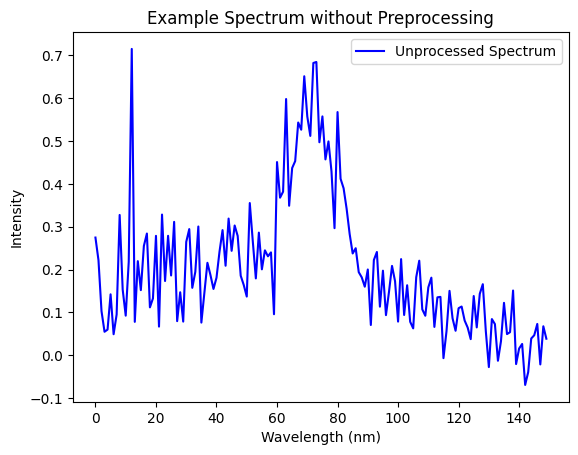

In [3]:
x, y = 150,150
plt.plot(data_list[0][y][x], c='blue', label='Unprocessed Spectrum')
plt.title("Example Spectrum without Preprocessing")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Intensity")
plt.legend()
plt.show()

# Testing the Model

In [4]:
def visualizeModel(data, classification_threshold = 0.995):
    """"
    Function to visualize the model output for a given dataset

    Args:
        model: The trained model to be used for inference
        data: The dataset to be used for inference
        classification_threshold: The threshold for classification
    Returns:
        material_mask: The binary material mask containing the classification results
        dopant_map: The dopant map containing the regression results
    """
    assert(len(data[0][0]) == 150)
    Y_sel, X_sel, W_sel = data.shape

    # Flatten spatial dimension for inference
    X_input = data.reshape((Y_sel * X_sel, W_sel))
    X_input = X_input[..., np.newaxis]

    classification_pred, regression_pred = model.predict(X_input, batch_size=32)
    classification_map = classification_pred.reshape((Y_sel, X_sel))
    dopant_map = regression_pred.reshape((Y_sel, X_sel))

    material_mask = (classification_map > classification_threshold).astype(float)
    dopant_map[material_mask == 0] = np.nan

    return material_mask, dopant_map

classification_results = []
regression_results = []
counter = 0

# Load in the trained model
model = tf.keras.models.load_model('Oxidation_Model/Ox_Class_Model.h5')

for data in data_list:
    print(f"File Number {counter}")
    model_result = visualizeModel(data)
    classification_results.append(model_result[0])
    regression_results.append(model_result[1])
    counter += 1

File Number 0
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step
File Number 1
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step
File Number 2
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step
File Number 3
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step
File Number 4
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step
File Number 5
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 36s 13ms/step
File Number 6
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 37s 13ms/step
File Number 7
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step
File Number 8
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step
File Number 9
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step
File Number 10
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step
File Number 11
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step
File Number 12
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step
File Number 13
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 34s 12ms/step
File Number 14
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step
File Number 15
2813/2813 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step


# Visualize Results

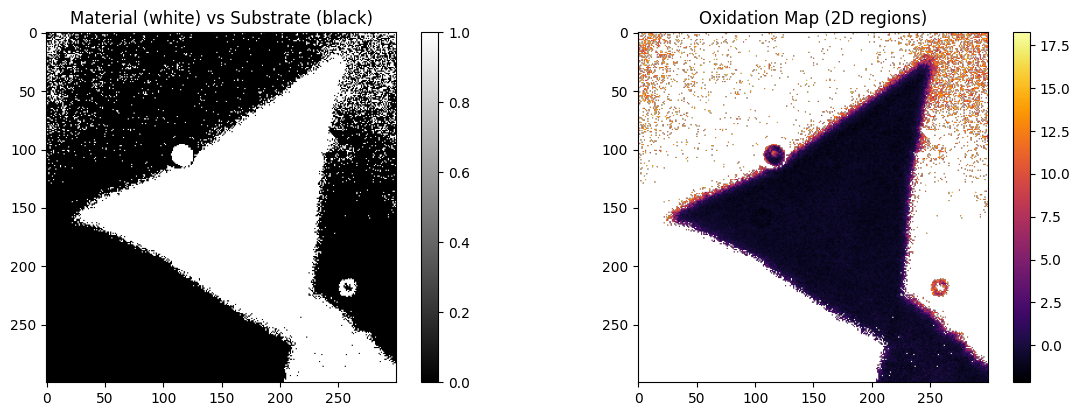

Example Oxidation Percentage: -0.8201152086257935
Example Classification (1): 1.0
Example Classification (0): 1.0


In [5]:
time_step = 0
plt.figure(figsize=(14, 10))

plt.subplot(2,2,1)
plt.imshow(classification_results[time_step], cmap='gray')
plt.title('Material (white) vs Substrate (black)')
plt.colorbar()

plt.subplot(2, 2, 2)
plt.imshow(regression_results[time_step], cmap='inferno')
plt.title('Oxidation Map (2D regions)')
plt.colorbar()

plt.show()

print(f"Example Oxidation Percentage: {regression_results[time_step][150][150]}")
print(f"Example Classification (1): {classification_results[time_step][150][150]}")
print(f"Example Classification (0): {classification_results[time_step][0][0]}")

# Model Evaluation

## Classification Results

In [6]:
def getAccuracyScore(Prediction, gt_Data):
    """
    Function to calculate the accuracy score of the model

    Args:
        Prediction: The predicted data
        gt_Data: The ground truth data
    Returns:
        correct / len(gt_Data): The accuracy score
    """
    Prediction = Prediction.flatten()
    assert(len(gt_Data) == len(Prediction))
    correct = 0
    for i in range(len(gt_Data)):
        if gt_Data[i] == Prediction[i]:
            correct += 1
    return correct / len(gt_Data)

accuracy_scores = []
for i in range(len(classification_results)):
    accuracy_scores.append(getAccuracyScore(classification_results[i], ground_truth_list[i]))

print(np.round(accuracy_scores, 4))

[0.937  0.8127 0.9486 0.9143 0.9563 0.9054 0.9117 0.9445 0.926  0.9279
 0.9063 0.9759 0.9451 0.9448 0.9515 0.9284]


# Regression Results

In [7]:
def getMedian(oxidation_map):
    """
    Function to calculate the median of the oxidation map

    Args:
        oxidation_map: The oxidation map to be used
    Returns:
        np.median(clean_map): The median of the oxidation map
    """
    oxidation_map = oxidation_map.flatten()
    clean_map = oxidation_map[~np.isnan(oxidation_map)]
    return np.median(clean_map)

medianVals = []
for time in regression_results:
    medianVals.append(getMedian(time))

print(np.round(medianVals, 4))

[-6.7680e-01  2.2870e-01  5.3640e-01 -2.9200e-02  4.0000e-04  4.9000e-02
  1.1660e-01  2.7630e-01  5.3580e-01  9.1200e-01  1.2576e+00  1.4962e+00
  2.4602e+00  2.7397e+00  3.1810e+00  3.5625e+00]


R² value: 0.7161
RMSE: 7.3516
MAE: 6.4596


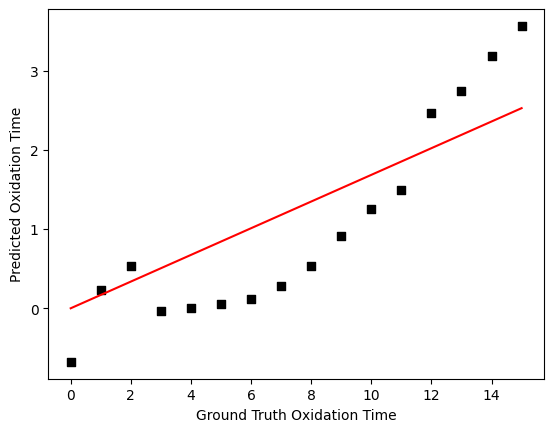

In [8]:
y0 = np.float32(0)
x = np.arange(0, 16, 1)
slope, _, _, _ = np.linalg.lstsq(x[:, np.newaxis], medianVals - y0, rcond=None)
y_fit = y0 + slope * x

# Calculate R-squared
y_mean = np.mean(medianVals)
ss_tot = np.sum((medianVals - y_mean) ** 2)
ss_res = np.sum((medianVals - y_fit) ** 2)
r_squared = 1 - (ss_res / ss_tot)

print(f"R² value: {r_squared:.4f}")
RMSE = root_mean_squared_error(x, medianVals)
MAE = mean_absolute_error(x, medianVals)
print(f"RMSE: {np.round(RMSE, 4)}")
print(f"MAE: {np.round(MAE, 4)}")

# Plot the fitted line with R² in legend
plt.plot(x, y_fit, label=f'Fitted Line (R² = {r_squared:.4f})', color='red')
plt.scatter(x, medianVals, c='black', marker='s', )
plt.xlabel('Ground Truth Oxidation Time')
plt.ylabel('Predicted Oxidation Time')
plt.show()